In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, date_format
from pyspark.sql.functions import col, max as max_, min as min_, stddev, stddev_pop, round, avg
from datetime import datetime, timezone, date, timedelta

from pyspark.sql.functions import lit, udf
from pyspark.sql import functions as F
import statistics
import warnings
import matplotlib.ticker as mticker

myLocator = mticker.MultipleLocator(4)
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [0]:
def fetch_data(start_date, end_date, device):
  end_next_date = str(datetime.fromisoformat(end_date) + timedelta(days=1)).split()[0]
  
  start_datetime = '(\'' + start_date + " " + start_time + '\')'
  end_datetime = '(\'' + end_next_date + " " + end_time + '\')'

  logfile_query = "select ConnectionDeviceID as ID, dt, Pressure1_PSI as p1, Pressure2_PSI as p2, Pressure3_PSI as p3, P1P2Delta, P2P3Delta from logfiles_dev where dt > cast({} as timestamp) and dt < cast({} as timestamp) and ConnectionDeviceID in ('{}')".format(start_datetime, end_datetime, device)

  logfile_df = spark.sql(logfile_query).cache()
  spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
  logfile_df = logfile_df.withColumn("Date", to_date(col("dt"),"yyyy-MM-dd")).withColumn("Time", date_format(col("dt"), "HH:mm:ss"))
  
  logfile_df.drop(col("dt"))
  logfile_meaned_df = logfile_df.groupBy('ID','Date','Time').agg(avg("p1"), avg("p2"), avg("p3"), avg("P1P2Delta"), avg("P2P3Delta"))
  logfile_meaned_df = logfile_meaned_df.withColumnRenamed("avg(p1)", "p1")\
                                          .withColumnRenamed("avg(p2)", "p2")\
                                          .withColumnRenamed("avg(p3)", "p3")\
                                          .withColumnRenamed("avg(P1P2Delta)", "P1P2Delta")\
                                          .withColumnRenamed("avg(P2P3Delta)", "P2P3Delta")
  
  logfile_meaned_df = logfile_meaned_df.toPandas()
  
  return logfile_meaned_df

In [0]:
def plot_raw(df, date, device):
  df = df[df['Date'] == date]
  df['Datetime'] = df['Date'].astype(str) + ' ' + df['Time']
  df['Datetime'] = pd.to_datetime(df['Datetime'])
  df.sort_values(by=['Datetime'], inplace=True)
  
  plt.figure(figsize=(10,5), dpi=100)
  ax=plt.gca()
  plt.title("{}: Device - {}, Date - {}".format('Original Data', device, date))
  plt.xlabel("Datetime")
  plt.ylabel("Pressure")
  p1=df['p1']
  p2=df['p2']
  p3=df['p3']
  plt.plot(df['Datetime'], p1, label='P1', color='tab:blue')
  plt.plot(df['Datetime'], p2, label='P2', color='tab:orange')
  plt.plot(df['Datetime'], p3, label='P3', color='tab:green')
  plt.legend(loc="lower left")
  plt.ylim(min(-1, p1.min()-2, p2.min()-2, p3.min()-2), max(100, p1.max(), p2.max(), p3.max()))
  plt.xticks(rotation=90)
  plt.show()

In [0]:
def plot_percentage(df_prcnt, device_list, month):
  plt.figure(figsize=(10,5), dpi=100)
  for device in device_list:
    df_temp = df_prcnt[df_prcnt['Device'] == device]
    if ((df_temp['Percent'].sum() == 0)):
      continue
    if (df_temp['Percent'].sum() > 2000):
      print(f'-----------------------{device}')
      continue
    plt.plot(df_temp['Date'], df_temp['Percent'], label=device)
  plt.legend(loc="upper right")
  plt.ylim(-1, 101)
  plt.title("Percentage of backpressure on daily basis - {} ".format(month))
  plt.xlabel("Date")
  plt.ylabel("Percentage (%)")
  plt.xticks(rotation=90)
  plt.show()
  
def plot_events(df_prcnt, device_list, month):
  plt.figure(figsize=(10,5), dpi=100)
  for device in device_list:
    df_temp = df_prcnt[df_prcnt['Device'] == device]
    if ((df_temp['Percent'].sum() == 0)):
      continue
    if (df_temp['Percent'].sum() > 2000):
      print(f'-----------------------{device}')
      continue
    plt.plot(df_temp['Date'], df_temp['Percent'], label=device)
  plt.legend(loc="upper right")
  plt.ylim(-1, 101)
  plt.title("# of backpressure on daily basis - {} ".format(month))
  plt.xlabel("Date")
  plt.ylabel("Percentage (%)")
  plt.xticks(rotation=90)
  plt.show()  

In [0]:
df_daterange = pd.read_csv('/dbfs/FileStore/tables/df_daterange.csv')
df_daterange.head(2)

Out[5]:

,Time,hour,period,15_min_interval,30_min_interval
0,00:00:00,0,12AM - 6AM,15_1_0,30_1_0
1,00:00:01,0,12AM - 6AM,15_1_0,30_1_0


In [0]:
month = 'dec'
start_date = '2022-12-01'
end_date = '2023-01-01'

start_time = '00:00:00'
end_time = '23:59:59.8'

dates_list = pd.date_range(start=start_date, end=end_date, freq='D')
dates_list = [str(i.date()) for i in dates_list]
dates_list[:3]

Out[6]: ['2022-12-01', '2022-12-02', '2022-12-03']

In [0]:
device_dict = {
  'WW1' : 5, 'WW-002-TE' : 0, 'WW-005-TE' : 6, 'WW-006-GF' : 5, 'WW8' : 6, 'WW-018-TE': 0, 'WW-021-TE' : 5, 'WW-022-GF' : 8, 
  'WW-023-TE' : 8, 'WW-024-TE' : 5, 'WW-026-TE' : 5, 'WW-032-TE' : 6, 'WW-033-TE' : 6, 'WW-035-TE' : 6, 'WW-039-TE' : 8, 
  'WW-041-TE' : 7, 'WW-042-TE' : 6, 'WW-043-TE' : 6, 'WW-044-TE' : 6, 'WW-045-TE' : 6, 'WW-049-TE' : 8, 'WW-051-TE' : 8, 
  'WW-053-TE' : 8, 'WW-055-TE' : 8, 'WW-056-TE' : 8, 'WW-066-TE' : 5, 'WW-066-TE_Testing' : 5, 'WW-067-TE' : 5, 'WW-068-TE' : 0,
  'WW-071-TE' : 5, 'WW-074-TE' : 8, 'WW-075-TE' : 8, 'WW-078-GF' : 8, 'WW-079-GF' : 8, 'WW-081-GF' : 8, 'WW-082-GF' : 8, 
  'WW-083-GF' : 8, 'WW-085-GF' : 8, 'WW-089-GF' : 5, 'WW-100-GF' : 0, 'W2-201-GF' : 0, 'W2-202-GF' : 0
}

device_list_all = [
  'WW1', 'WW-002-TE', 'WW-005-TE', 'WW-006-GF', 'WW-007-TE', 'WW8', 'WW-009-TE', 'WW-010-TE', 'WW-011-TE', 'WW-012-TE', 'WW-013-TE', 
  'WW-014-TE', 'WW-015-TE', 'WW-016-TE', 'WW-017-TE', 'WW-018-TE', 'WW-019-TE', 'WW-020-TE', 'WW-021-TE', 'WW-022-GF', 'WW-023-TE', 
  'WW-024-TE', 'WW-025-TE', 'WW-026-TE', 'WW-027-TE', 'WW-028-TE', 'WW-029-TE', 'WW-030-TE', 'WW-031-TE', 'WW-031-TE', 'WW-032-TE', 
  'WW-033-TE', 'WW-034-TE', 'WW-035-TE', 'WW-036-TE', 'WW-037-TE', 'WW-038-TE', 'WW-039-TE', 'WW-040-TE', 'WW-041-TE', 'WW-042-TE', 
  'WW-043-TE', 'WW-044-TE', 'WW-045-TE', 'WW-046-TE', 'WW-047-TE', 'WW-048-TE', 'WW-049-TE', 'WW-050-TE', 'WW-051-TE', 'WW-052-TE', 
  'WW-053-TE', 'WW-054-TE', 'WW-055-TE', 'WW-056-TE', 'WW-057-TE', 'WW-058-TE', 'WW-059-TE', 'WW-060-TE', 'WW-061-TE', 'WW-062-TE', 
  'WW-063-TE', 'WW-064-TE', 'WW-065-TE', 'WW-066-TE', 'WW-067-GF', 'WW-068-TE', 'WW-069-TE', 'WW-070-TE', 'WW-071-TE', 'WW-072-GF', 
  'WW-073-GF', 'WW-074-TE', 'WW-075-TE', 'WW-076-GF', 'WW-077-GF', 'WW-078-GF', 'WW-079-GF', 'WW-080-GF', 'WW-081-GF', 'WW-082-GF', 
  'WW-083-GF', 'WW-084-GF', 'WW-085-GF', 'WW-086-GF', 'WW-087-GF', 'WW-088-GF', 'WW-089-GF', 'WW-090-GF', 'WW-091_GF', 'WW-092-GF', 
  'WW-093-GF', 'WW-094-GF', 'WW-095-GF', 'WW-096-GF', 'WW-097-GF', 'WW-098-GF', 'WW-099-GF', 'WW-100-GF', 'WW-101-TE', 
  'WW-102-TE', 'WW-103-TE', 'WW-104-TE'
] 

In [0]:
ignore_list = list()
for device in device_list_all:
  print(device)
  try:
    df = fetch_data(start_date, end_date, device)
    df.to_csv('/dbfs/FileStore/tables/{}_{}.csv'.format(device, month), index=None)
    print('{}_nov.csv'.format(device))
    print(df.shape)
    if df.shape[0] == 0:
      ignore_list.append(device)
    print('\n')
  except Exception as e:
    print(e)

WW1
WW1_nov.csv
(0, 8)


WW-002-TE
WW-002-TE_nov.csv
(2203996, 8)


WW-005-TE
WW-005-TE_nov.csv
(2836206, 8)


WW-006-GF
WW-006-GF_nov.csv
(2825478, 8)


WW-007-TE
WW-007-TE_nov.csv
(0, 8)


WW8
WW8_nov.csv
(2839531, 8)


WW-009-TE
WW-009-TE_nov.csv
(0, 8)


WW-010-TE
WW-010-TE_nov.csv
(0, 8)


WW-011-TE
WW-011-TE_nov.csv
(0, 8)


WW-012-TE
WW-012-TE_nov.csv
(0, 8)


WW-013-TE
WW-013-TE_nov.csv
(0, 8)


WW-014-TE
WW-014-TE_nov.csv
(0, 8)


WW-015-TE
WW-015-TE_nov.csv
(0, 8)


WW-016-TE
WW-016-TE_nov.csv
(0, 8)


WW-017-TE
WW-017-TE_nov.csv
(0, 8)


WW-018-TE
WW-018-TE_nov.csv
(2388456, 8)


WW-019-TE
WW-019-TE_nov.csv
(0, 8)


WW-020-TE
WW-020-TE_nov.csv
(0, 8)


WW-021-TE
WW-021-TE_nov.csv
(2836041, 8)


WW-022-GF
WW-022-GF_nov.csv
(2634299, 8)


WW-023-TE
WW-023-TE_nov.csv
(2832421, 8)


WW-024-TE
WW-024-TE_nov.csv
(2837610, 8)


WW-025-TE
WW-025-TE_nov.csv
(0, 8)


WW-026-TE
WW-026-TE_nov.csv
(2302210, 8)


WW-027-TE
WW-027-TE_nov.csv
(0, 8)


WW-028-TE
WW-028-TE_nov.csv
(0, 8)


WW-029-TE
WW-029-TE_nov.csv
(0, 8)


WW-030-TE
WW-030-TE_nov.csv
(0, 8)


WW-031-TE
WW-031-TE_nov.csv
(0, 8)


WW-031-TE
WW-031-TE_nov.csv
(0, 8)


WW-032-TE
WW-032-TE_nov.csv
(0, 8)


WW-033-TE
WW-033-TE_nov.csv
(2617116, 8)


WW-034-TE
WW-034-TE_nov.csv
(0, 8)


WW-035-TE
WW-035-TE_nov.csv
(0, 8)


WW-036-TE
WW-036-TE_nov.csv
(0, 8)


WW-037-TE
WW-037-TE_nov.csv
(0, 8)


WW-038-TE
WW-038-TE_nov.csv
(0, 8)


WW-039-TE
WW-039-TE_nov.csv
(2839579, 8)


WW-040-TE
WW-040-TE_nov.csv
(0, 8)


WW-041-TE
WW-041-TE_nov.csv
(2838036, 8)


WW-042-TE
WW-042-TE_nov.csv
(0, 8)


WW-043-TE
WW-043-TE_nov.csv
(0, 8)


WW-044-TE
WW-044-TE_nov.csv
(0, 8)


WW-045-TE
WW-045-TE_nov.csv
(0, 8)


WW-046-TE
WW-046-TE_nov.csv
(0, 8)


WW-047-TE
WW-047-TE_nov.csv
(0, 8)


WW-048-TE
WW-048-TE_nov.csv
(20359, 8)


WW-049-TE
WW-049-TE_nov.csv
(2841099, 8)


WW-050-TE
WW-050-TE_nov.csv
(0, 8)


WW-051-TE
WW-051-TE_nov.csv
(2703367, 8)


WW-052-TE
WW-052-TE_nov.csv
(0, 8)


WW-053-TE
WW-053-TE_nov.csv
(2834502, 8)


WW-054-TE
WW-054-TE_nov.csv
(0, 8)


WW-055-TE
WW-055-TE_nov.csv
(2840891, 8)


WW-056-TE
WW-056-TE_nov.csv
(2797409, 8)


WW-057-TE
WW-057-TE_nov.csv
(0, 8)


WW-058-TE
WW-058-TE_nov.csv
(0, 8)


WW-059-TE
WW-059-TE_nov.csv
(0, 8)


WW-060-TE
WW-060-TE_nov.csv
(0, 8)


WW-061-TE
WW-061-TE_nov.csv
(0, 8)


WW-062-TE
WW-062-TE_nov.csv
(0, 8)


WW-063-TE
WW-063-TE_nov.csv
(0, 8)


WW-064-TE
WW-064-TE_nov.csv
(0, 8)


WW-065-TE
WW-065-TE_nov.csv
(0, 8)


WW-066-TE
WW-066-TE_nov.csv
(0, 8)


WW-067-GF
WW-067-GF_nov.csv
(0, 8)


WW-068-TE
WW-068-TE_nov.csv
(2834467, 8)


WW-069-TE
WW-069-TE_nov.csv
(0, 8)


WW-070-TE
WW-070-TE_nov.csv
(0, 8)


WW-071-TE
WW-071-TE_nov.csv
(2575207, 8)


WW-072-GF
WW-072-GF_nov.csv
(0, 8)


WW-073-GF
WW-073-GF_nov.csv
(0, 8)


WW-074-TE
WW-074-TE_nov.csv
(2839223, 8)


WW-075-TE
WW-075-TE_nov.csv
(2839124, 8)


WW-076-GF
WW-076-GF_nov.csv
(0, 8)


WW-077-GF
WW-077-GF_nov.csv
(0, 8)


WW-078-GF
WW-078-GF_nov.csv
(2831356, 8)


WW-079-GF
WW-079-GF_nov.csv
(2830993, 8)


WW-080-GF
WW-080-GF_nov.csv
(0, 8)


WW-081-GF
WW-081-GF_nov.csv
(2808766, 8)


WW-082-GF
WW-082-GF_nov.csv
(2827706, 8)


WW-083-GF
WW-083-GF_nov.csv
(2626198, 8)


WW-084-GF
WW-084-GF_nov.csv
(0, 8)


WW-085-GF
WW-085-GF_nov.csv
(2818397, 8)


WW-086-GF
WW-086-GF_nov.csv
(0, 8)


WW-087-GF
WW-087-GF_nov.csv
(0, 8)


WW-088-GF
WW-088-GF_nov.csv
(0, 8)


WW-089-GF
WW-089-GF_nov.csv
(0, 8)


WW-090-GF
WW-090-GF_nov.csv
(0, 8)


WW-091_GF
WW-091_GF_nov.csv
(0, 8)


WW-092-GF
WW-092-GF_nov.csv
(0, 8)


WW-093-GF
WW-093-GF_nov.csv
(0, 8)


WW-094-GF
WW-094-GF_nov.csv
(0, 8)


WW-095-GF
WW-095-GF_nov.csv
(0, 8)


WW-096-GF
WW-096-GF_nov.csv
(0, 8)


WW-097-GF
WW-097-GF_nov.csv
(0, 8)


WW-098-GF
WW-098-GF_nov.csv
(0, 8)


WW-099-GF
WW-099-GF_nov.csv
(0, 8)


WW-100-GF
WW-100-GF_nov.csv
(0, 8)


WW-101-TE
WW-101-TE_nov.csv
(0, 8)


WW-102-TE
WW-102-TE_nov.csv
(0, 8)


WW-103-TE
WW-103-TE_nov.csv
(0, 8)


WW-104-TE
WW-104-TE_nov.csv
(0, 8)

In [0]:
device_list = [device for device in device_list_all if device not in ignore_list]
print(device_list)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1309911505686490> in <module> 
 ----> 1 device_list = [ device for device in device_list_all if device not in ignore_list ] 
 2 print ( device_list ) 

 <command-1309911505686490> in <listcomp> (.0) 
 ----> 1 device_list = [ device for device in device_list_all if device not in ignore_list ] 
 2 print ( device_list ) 

 NameError : name 'ignore_list' is not defined

In [0]:
df_prcnt = pd.DataFrame()
for device in device_list:
  print('-----------------------------------')
  print(device)
  df = pd.read_csv('/dbfs/FileStore/tables/{}_{}.csv'.format(device, month))
  # df = df[df['Date'] < '2022-11-01'] # This needs to be uncommented only for Oct 2022
  df.sort_values(by=['Date','Time'], inplace=True)
  print(df.shape)
  
  df['p3_gt_p2plus1_flag'] = np.where(df['p3'] > (df['p2'] + 1),1,0)
  df['flag_counter'] = df.groupby('ID').apply(lambda x: x['p3_gt_p2plus1_flag'].fillna(0).diff().ne(0).cumsum())\
    .reset_index(level=0, drop=True).T
  df['flag_counter'] = np.where(df['p3_gt_p2plus1_flag'] == 0, 0, df['flag_counter'])
  flag_counter_df = df['flag_counter'].value_counts().reset_index()
  flag_counter_df = flag_counter_df[(flag_counter_df['flag_counter'] > 1200) & (flag_counter_df['index'] != 0)]

  df['flag_counter_gt_20min'] = df['flag_counter'].isin(flag_counter_df['index'])
  
  df_prcnt_temp = df.groupby('Date')['flag_counter_gt_20min'].sum()*100/df.groupby('Date')['Date'].count()
  df_prcnt_temp = df_prcnt_temp.reset_index()
  df_prcnt_temp.columns = ['Date', 'Percent']
  df_prcnt_temp['Device'] = device
  
  df_prcnt = pd.concat([df_prcnt, df_prcnt_temp], axis=0)
  print('\n')
df_prcnt.to_csv('/dbfs/FileStore/tables/{}_{}.csv'.format('backpressure_precentage',month), index=None)

-----------------------------------
WW-002-TE
(2203996, 8)


-----------------------------------
WW-005-TE
(2836206, 8)


-----------------------------------
WW-006-GF
(2825478, 8)


-----------------------------------
WW8
(2839531, 8)


-----------------------------------
WW-018-TE
(2388456, 8)


-----------------------------------
WW-021-TE
(2836041, 8)


-----------------------------------
WW-022-GF
(2634299, 8)


-----------------------------------
WW-023-TE
(2832421, 8)


-----------------------------------
WW-024-TE
(2837610, 8)


-----------------------------------
WW-026-TE
(2302210, 8)


-----------------------------------
WW-033-TE
(2617116, 8)


-----------------------------------
WW-039-TE
(2839579, 8)


-----------------------------------
WW-041-TE
(2838036, 8)


-----------------------------------
WW-048-TE
(20359, 8)


-----------------------------------
WW-049-TE
(2841099, 8)


-----------------------------------
WW-051-TE
(2703367, 8)


-----------------------------------
WW-053-TE
(2834502, 8)


-----------------------------------
WW-055-TE
(2840891, 8)


-----------------------------------
WW-056-TE
(2797409, 8)


-----------------------------------
WW-068-TE
(2834467, 8)


-----------------------------------
WW-071-TE
(2575207, 8)


-----------------------------------
WW-074-TE
(2839223, 8)


-----------------------------------
WW-075-TE
(2839124, 8)


-----------------------------------
WW-078-GF
(2831356, 8)


-----------------------------------
WW-079-GF
(2830993, 8)


-----------------------------------
WW-081-GF
(2808766, 8)


-----------------------------------
WW-082-GF
(2827706, 8)


-----------------------------------
WW-083-GF
(2626198, 8)


-----------------------------------
WW-085-GF
(2818397, 8)

In [0]:
df_prcnt.head()

Out[11]:

,Date,Percent,Device
0,2022-11-01,100.0,WW-002-TE
1,2022-11-02,100.0,WW-002-TE
2,2022-11-03,100.0,WW-002-TE
3,2022-11-04,100.0,WW-002-TE
4,2022-11-05,100.0,WW-002-TE


-----------------------WW-002-TE
-----------------------WW-018-TE
-----------------------WW-023-TE
-----------------------WW-056-TE
-----------------------WW-078-GF
-----------------------WW-082-GF
-----------------------WW-083-GF

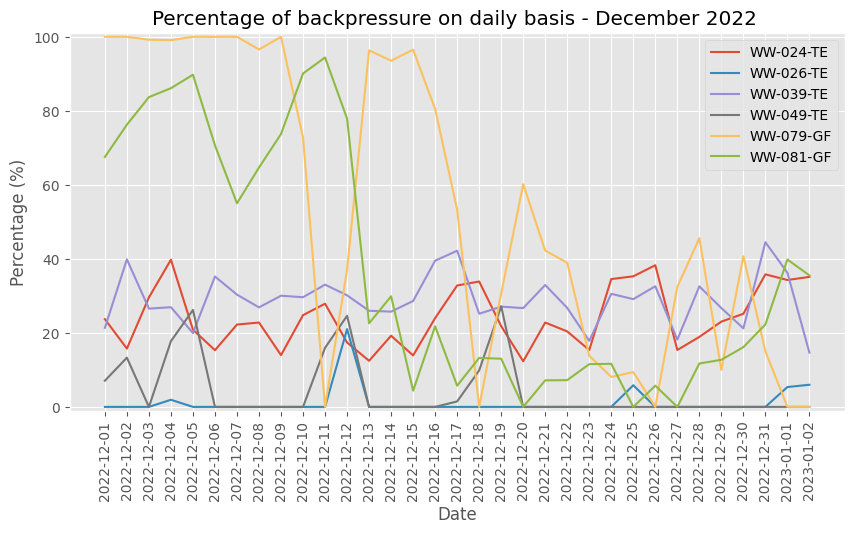

In [0]:
month_name = 'December 2022'
plot_percentage(df_prcnt, device_list, month=month_name)

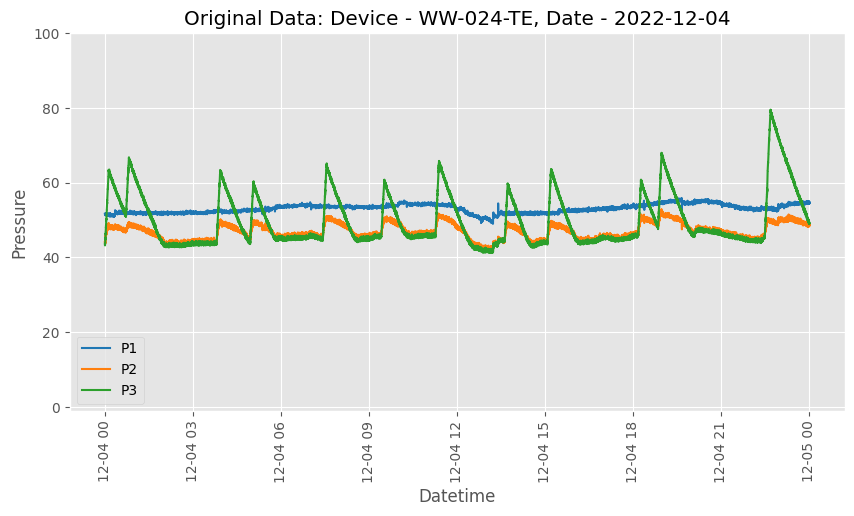

In [0]:
device='WW-024-TE'
date = '2022-12-04'

df = pd.read_csv('/dbfs/FileStore/tables/{}_{}.csv'.format(device, 'dec'))
plot_raw(df=df, date=date, device=device)

In [0]:
# Only devices with backpressure are considered
device_list = ['WW-002-TE', 'WW8', 'WW-018-TE', 'WW-023-TE', 'WW-024-TE', 'WW-026-TE', 'WW-039-TE', 'WW-049-TE', 'WW-051-TE', 
               'WW-056-TE', 'WW-078-GF', 'WW-079-TE', 'WW-081-TE', 'WW-082-GF', 'WW-083-GF']
month = 'oct'

In [0]:
df_prcnt = pd.DataFrame()
for device in device_list:
    try:
      print('-----------------------------------')
      print(device)
      df = pd.read_csv('/dbfs/FileStore/tables/{}_{}.csv'.format(device, month))
      # df = df[df['Date'] < '2022-11-01'] # This needs to be uncommented only for Oct 2022
      df.sort_values(by=['Date','Time'], inplace=True)
      print(df.shape)

      df['p3_gt_p2plus1_flag'] = np.where(df['p3'] > (df['p2'] + 5),1,0)
      df['flag_counter'] = df.groupby('ID').apply(lambda x: x['p3_gt_p2plus1_flag'].fillna(0).diff().ne(0).cumsum())\
        .reset_index(level=0, drop=True).T
      df['flag_counter'] = np.where(df['p3_gt_p2plus1_flag'] == 0, 0, df['flag_counter'])
      flag_counter_df = df['flag_counter'].value_counts().reset_index()
      flag_counter_df = flag_counter_df[(flag_counter_df['flag_counter'] > 1200) & (flag_counter_df['index'] != 0)]

      df['flag_counter_gt_20min'] = df['flag_counter'].isin(flag_counter_df['index'])

      df_prcnt_temp = df.groupby('Date')['flag_counter_gt_20min'].sum()*100/df.groupby('Date')['Date'].count()
      df_prcnt_temp = df_prcnt_temp.reset_index()
      df_prcnt_temp.columns = ['Date', 'Percent']
      df_prcnt_temp['Device'] = device

      df_prcnt = pd.concat([df_prcnt, df_prcnt_temp], axis=0)
      print('\n')
    except Exception:
      pass
df_prcnt.to_csv('/dbfs/FileStore/tables/{}_{}_5.csv'.format('backpressure_precentage',month), index=None)

-----------------------------------
WW-002-TE
(2748158, 8)


-----------------------------------
WW8
(3701429, 8)


-----------------------------------
WW-018-TE
(1812856, 8)


-----------------------------------
WW-023-TE
(3687786, 8)


-----------------------------------
WW-024-TE
(3698312, 8)


-----------------------------------
WW-026-TE
(2743693, 8)


-----------------------------------
WW-039-TE
(3697017, 8)


-----------------------------------
WW-049-TE
(3702223, 8)


-----------------------------------
WW-051-TE
(3571740, 8)


-----------------------------------
WW-056-TE
(3696975, 8)


-----------------------------------
WW-078-GF
(3694766, 8)


-----------------------------------
WW-079-TE
-----------------------------------
WW-081-TE
-----------------------------------
WW-082-GF
(3636428, 8)


-----------------------------------
WW-083-GF
(3642624, 8)

-----------------------WW-002-TE
-----------------------WW-018-TE
-----------------------WW-078-GF
-----------------------WW-082-GF
-----------------------WW-083-GF

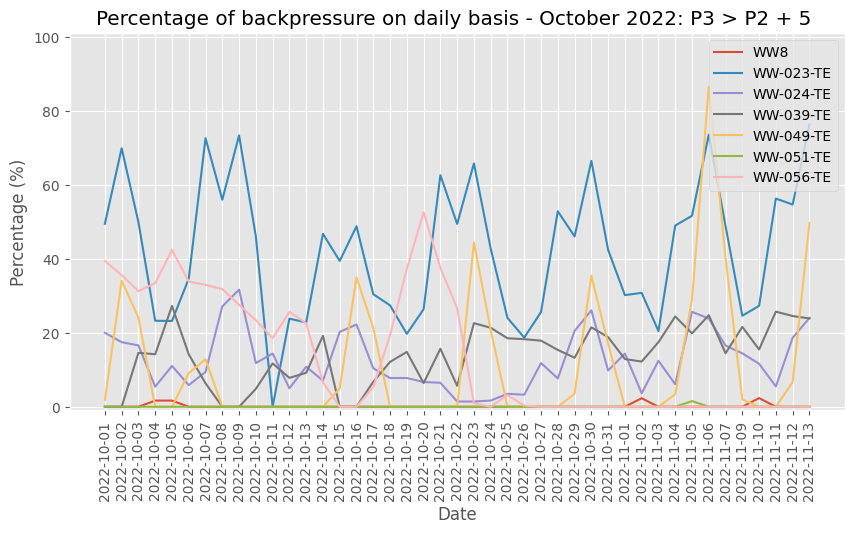

In [0]:
month_name = 'October 2022'
plot_percentage(df_prcnt, device_list, month=month_name + ': P3 > P2 + 5')

In [0]:
# Only devices with backpressure for a particular month with P3 > P2+1 are considered
device_list = ['WW-002-TE', 'WW8', 'WW-018-TE', 'WW-023-TE', 'WW-024-TE', 'WW-026-TE', 'WW-039-TE', 'WW-049-TE', 'WW-051-TE', 
               'WW-056-TE', 'WW-078-GF', 'WW-079-TE', 'WW-081-TE', 'WW-082-GF', 'WW-083-GF']
month = 'oct'

In [0]:
df_prcnt = pd.DataFrame()
for device in device_list:
    try:
      print('-----------------------------------')
      print(device)
      df = pd.read_csv('/dbfs/FileStore/tables/{}_{}.csv'.format(device, month))
      # df = df[df['Date'] < '2022-11-01'] # This needs to be uncommented only for Oct 2022
      df.sort_values(by=['Date','Time'], inplace=True)
      print(df.shape)

      df['p3_gt_p2plus1_flag'] = np.where(df['p3'] > (df['p2'] + 10),1,0)
      df['flag_counter'] = df.groupby('ID').apply(lambda x: x['p3_gt_p2plus1_flag'].fillna(0).diff().ne(0).cumsum())\
        .reset_index(level=0, drop=True).T
      df['flag_counter'] = np.where(df['p3_gt_p2plus1_flag'] == 0, 0, df['flag_counter'])
      flag_counter_df = df['flag_counter'].value_counts().reset_index()
      flag_counter_df = flag_counter_df[(flag_counter_df['flag_counter'] > 1200) & (flag_counter_df['index'] != 0)]

      df['flag_counter_gt_20min'] = df['flag_counter'].isin(flag_counter_df['index'])

      df_prcnt_temp = df.groupby('Date')['flag_counter_gt_20min'].sum()*100/df.groupby('Date')['Date'].count()
      df_prcnt_temp = df_prcnt_temp.reset_index()
      df_prcnt_temp.columns = ['Date', 'Percent']
      df_prcnt_temp['Device'] = device

      df_prcnt = pd.concat([df_prcnt, df_prcnt_temp], axis=0)
      print('\n')
    except Exception:
      pass
df_prcnt.to_csv('/dbfs/FileStore/tables/{}_{}_10.csv'.format('backpressure_precentage',month), index=None)

-----------------------------------
WW-002-TE
(2748158, 8)


-----------------------------------
WW8
(3701429, 8)


-----------------------------------
WW-018-TE
(1812856, 8)


-----------------------------------
WW-023-TE
(3687786, 8)


-----------------------------------
WW-024-TE
(3698312, 8)


-----------------------------------
WW-026-TE
(2743693, 8)


-----------------------------------
WW-039-TE
(3697017, 8)


-----------------------------------
WW-049-TE
(3702223, 8)


-----------------------------------
WW-051-TE
(3571740, 8)


-----------------------------------
WW-056-TE
(3696975, 8)


-----------------------------------
WW-078-GF
(3694766, 8)


-----------------------------------
WW-079-TE
-----------------------------------
WW-081-TE
-----------------------------------
WW-082-GF
(3636428, 8)


-----------------------------------
WW-083-GF
(3642624, 8)

-----------------------WW-002-TE
-----------------------WW-078-GF
-----------------------WW-082-GF
-----------------------WW-083-GF

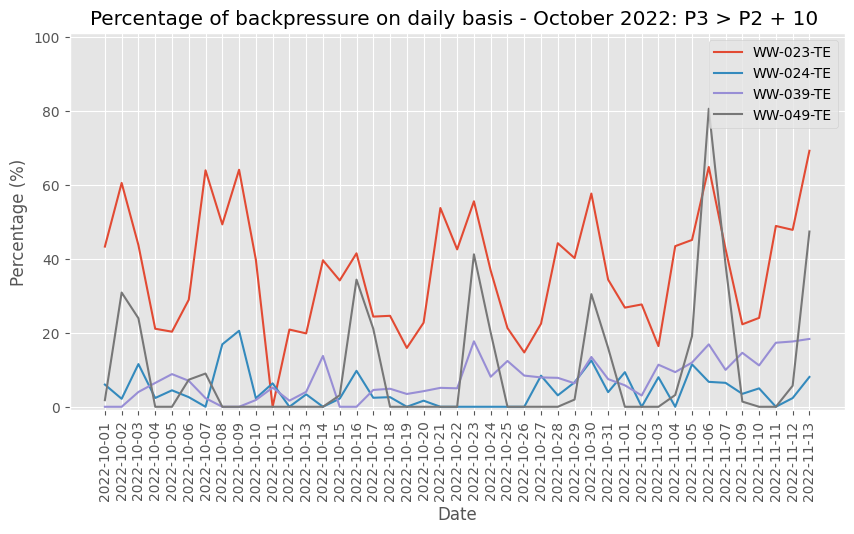

In [0]:
month_name = 'October 2022'
plot_percentage(df_prcnt, device_list, month=month_name + ': P3 > P2 + 10')

In [0]:
df_prcnt.sample(10)

Out[40]:

,Date,Percent,Device
25,2022-10-26,0.000000,WW8
5,2022-10-06,28.919816,WW-023-TE
42,2022-11-13,47.351374,WW-049-TE
8,2022-10-09,0.000000,WW-056-TE
22,2022-10-23,0.000000,WW-026-TE
41,2022-11-12,100.000000,WW-078-GF
6,2022-10-07,0.000000,WW-051-TE
10,2022-10-11,0.000000,WW-023-TE
33,2022-11-04,100.000000,WW-002-TE
29,2022-10-30,13.454207,WW-039-TE


In [0]:
def get_data_events(month, threshold):
  df_prcnt = pd.DataFrame()
  for device in device_list:
    try:
      print('-----------------------------------')
      print(device)
      df = pd.read_csv('/dbfs/FileStore/tables/{}_{}.csv'.format(device, month))
      # df = df[df['Date'] < '2022-11-01'] # This needs to be uncommented only for Oct 2022
      df.sort_values(by=['Date','Time'], inplace=True)
      print(df.shape)

      df['p3_gt_p2plus1_flag'] = np.where(df['p3'] > (df['p2'] + threshold),1,0)
      df['flag_counter'] = df.groupby('ID').apply(lambda x: x['p3_gt_p2plus1_flag'].fillna(0).diff().ne(0).cumsum())\
        .reset_index(level=0, drop=True).T
      df['flag_counter'] = np.where(df['p3_gt_p2plus1_flag'] == 0, 0, df['flag_counter'])
      flag_counter_df = df['flag_counter'].value_counts().reset_index()
      flag_counter_df = flag_counter_df[(flag_counter_df['flag_counter'] > 1200) & (flag_counter_df['index'] != 0)]

      df['flag_counter_gt_20min'] = df['flag_counter'].isin(flag_counter_df['index'])

      df_prcnt_temp = df.groupby('Date')['flag_counter_gt_20min'].sum()
      df_prcnt_temp = df_prcnt_temp.reset_index()
      df_prcnt_temp.columns = ['Date', 'Percent']
      df_prcnt_temp['Device'] = device

      df_prcnt = pd.concat([df_prcnt, df_prcnt_temp], axis=0)
      print('\n')
    except Exception as e:
      print(e)

  df_prcnt.to_csv('/dbfs/FileStore/tables/{}_{}_events.csv'.format('backpressure_precentage',month), index=None)
  return df_prcnt

In [0]:
# Only devices with backpressure are considered
device_list = ['WW-002-TE', 'WW8', 'WW-018-TE', 'WW-023-TE', 'WW-024-TE', 'WW-026-TE', 'WW-039-TE', 'WW-049-TE', 'WW-051-TE', 
               'WW-056-TE', 'WW-078-GF', 'WW-079-TE', 'WW-081-TE', 'WW-082-GF', 'WW-083-GF']
month = 'dec'

In [0]:
df_prcnt = get_data_events(month=month, threshold=1)

-----------------------------------
WW-002-TE
(2203996, 8)


-----------------------------------
WW8
(2839531, 8)


-----------------------------------
WW-018-TE
(2388456, 8)


-----------------------------------
WW-023-TE
(2832421, 8)


-----------------------------------
WW-024-TE
(2837610, 8)


-----------------------------------
WW-026-TE
(2302210, 8)


-----------------------------------
WW-039-TE
(2839579, 8)


-----------------------------------
WW-049-TE
(2841099, 8)


-----------------------------------
WW-051-TE
(2703367, 8)


-----------------------------------
WW-056-TE
(2797409, 8)


-----------------------------------
WW-078-GF
(2831356, 8)


-----------------------------------
WW-079-TE
[Errno 2] No such file or directory: '/dbfs/FileStore/tables/WW-079-TE_dec.csv'
-----------------------------------
WW-081-TE
[Errno 2] No such file or directory: '/dbfs/FileStore/tables/WW-081-TE_dec.csv'
-----------------------------------
WW-082-GF
(2827706, 8)


-----------------------------------
WW-083-GF
(2626198, 8)

In [0]:
month_name = 'December 2022'
plot_events(df_prcnt, device_list, month=month_name)

In [0]:
  threshold = 1
  df_prcnt = pd.DataFrame()
  for device in device_list[:1]:
    try:
      print('-----------------------------------')
      print(device)
      df = pd.read_csv('/dbfs/FileStore/tables/{}_{}.csv'.format(device, month))
      # df = df[df['Date'] < '2022-11-01'] # This needs to be uncommented only for Oct 2022
      df.sort_values(by=['Date','Time'], inplace=True)
      print(df.shape)

      df['p3_gt_p2plus1_flag'] = np.where(df['p3'] > (df['p2'] + threshold),1,0)
      df['flag_counter'] = df.groupby('ID').apply(lambda x: x['p3_gt_p2plus1_flag'].fillna(0).diff().ne(0).cumsum())\
        .reset_index(level=0, drop=True).T
      df['flag_counter'] = np.where(df['p3_gt_p2plus1_flag'] == 0, 0, df['flag_counter'])
      flag_counter_df = df['flag_counter'].value_counts().reset_index()
      flag_counter_df = flag_counter_df[(flag_counter_df['flag_counter'] > 1200) & (flag_counter_df['index'] != 0)]

      df['flag_counter_gt_20min'] = df['flag_counter'].isin(flag_counter_df['index'])

      df_prcnt_temp = df.groupby('Date')['flag_counter_gt_20min'].sum()
      df_prcnt_temp = df_prcnt_temp.reset_index()
      df_prcnt_temp.columns = ['Date', 'Percent']
      df_prcnt_temp['Device'] = device

      df_prcnt = pd.concat([df_prcnt, df_prcnt_temp], axis=0)
      print('\n')
    except Exception as e:
      print(e)


-----------------------------------
WW-002-TE
(2203996, 8)

In [0]:
flag_counter_df

Out[54]:

,index,flag_counter
0,1,2203996


In [0]:
df

Out[55]:

,ID,Date,Time,p1,p2,p3,P1P2Delta,P2P3Delta,p3_gt_p2plus1_flag,flag_counter,flag_counter_gt_20min
1816013,WW-002-TE,2022-12-01,00:00:00,105.269231,-1.527473,101.703297,106.796703,-103.230769,1,1,True
1818605,WW-002-TE,2022-12-01,00:00:01,106.357143,-1.587912,103.214286,107.945055,-104.802198,1,1,True
1875863,WW-002-TE,2022-12-01,00:00:02,104.241758,-1.587912,102.126374,105.829670,-103.714286,1,1,True
422151,WW-002-TE,2022-12-01,00:00:03,105.692308,-1.527473,102.428571,107.219780,-103.956044,1,1,True
1771177,WW-002-TE,2022-12-01,00:00:04,105.208791,-1.527473,102.428571,106.736264,-103.956044,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...
863873,WW-002-TE,2023-01-02,23:59:55,105.813187,-1.708791,102.489011,107.521978,-104.197802,1,1,True
1352339,WW-002-TE,2023-01-02,23:59:56,105.450549,-1.648352,102.670330,107.098901,-104.318681,1,1,True
1644503,WW-002-TE,2023-01-02,23:59:57,105.571429,-1.587912,102.609890,107.159341,-104.197802,1,1,True
2019498,WW-002-TE,2023-01-02,23:59:58,105.571429,-1.648352,102.368132,107.219780,-104.016484,1,1,True
